# DTS with wine quality analisis
* German Bueno Lozano
* Arnau Gonzalez Almirall

In [136]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree


In [19]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
df=pd.concat([X,y],axis=1)

In [20]:
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# Data exploration

Procedemos a observar si hay valores nulos

In [22]:
df.isnull().sum() 

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Como se puede observar, no hay valores nulos, si los hubiera la mejor estrategia a seguit hubiera sido usar un KNN Imputer para mantener las relaciones con el resto de datos

In [34]:
#Escalar los datos con StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Aplicar PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

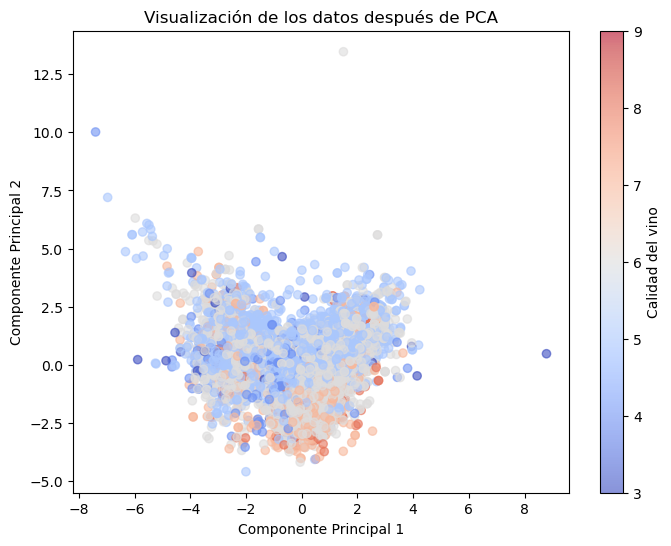

In [46]:
#Visualizar los datos después del PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.array(y), cmap="coolwarm", alpha=0.6)
plt.colorbar(label="Calidad del vino")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualización de los datos después de PCA")
plt.show()

# Decision tree regressor

Ahora procederemos a evaluar cual es la mejor profundidad del arbol de decisiones, para ello usaremos el criterio del mean squared error (MSE). Aquel modelo el cual al evaluarlo nos de el menor error cuadratico, definira la profundidad del arbol 

In [82]:
#Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5️⃣ Probar diferentes valores de max_depth
max_depths = range(1, 201)  # Probamos de 1 a 20 niveles de profundidad
mse_scores = []

for depth in max_depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    mse = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    mse_scores.append(mse)

# 6️⃣ Encontrar el mejor max_depth
best_depth = max_depths[np.argmin(mse_scores)]
print(f"Mejor profundidad del árbol: {best_depth}")


Mejor profundidad del árbol: 6


In [88]:
# Reentrenar con la mejor profundida
best_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [90]:
#Evaluar el modelo final
mse_final = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio del mejor modelo: {mse_final:.2f}")

Error cuadrático medio del mejor modelo: 0.58


Viendo que 6 parece la mejor profundidad para el arbol de decisiones, vamos a ver si podemos mejorar el MSE aplicando otros criterios. Nota: como veremos en el param grid, no aparece ni gini ni entropy, hay que recordar que estos criterios son validos para clasificacion y no para regresion.

In [128]:
# 5️⃣ Definir los hiperparámetros a probar
param_grid = {
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "max_depth": [6, 10, 20, 30, 1, 3],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

# 6️⃣ Usar GridSearchCV para encontrar la mejor combinación de hiperparámetros
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 7️⃣ Obtener los mejores parámetros encontrados
best_params = grid_search.best_params_
print(f"✅ Mejores parámetros encontrados: {best_params}")

# 8️⃣ Entrenar el modelo con los mejores parámetros
best_model = DecisionTreeRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# 9️⃣ Hacer predicciones
y_pred = best_model.predict(X_test)

# 🔟 Evaluar el modelo final
mse_final = mean_squared_error(y_test, y_pred)
r2_final = r2_score(y_test, y_pred)

print(f"📉 Error cuadrático medio (MSE): {mse_final:.2f}")
print(f"📊 Coeficiente de determinación (R²): {r2_final:.2f}")

✅ Mejores parámetros encontrados: {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}
📉 Error cuadrático medio (MSE): 0.56
📊 Coeficiente de determinación (R²): 0.24


Como podemos ver, los mejores parametros son:
* criterio: error cuadratico (este es el criterio por defecto de DecisionTreeRegressor)
* profundidad maxima: 6 (lo que habiamos encontrado sin grid_search CV)

Con estos parametros, vemos que nos sale un r^2 muy bajo incluso en comparacion con otros algoritmos como la kNN.

## 🔍 Posibles razones del bajo R^2
 
1️⃣ El dataset es difícil para regresión con árboles de decisión
El Wine Quality Dataset tiene datos continuos, pero la variable objetivo (quality) es casi categórica (toma valores discretos entre 3 y 9).

🔹 Los árboles de decisión funcionan mejor con patrones estructurados, y en este dataset, la relación entre las características y la calidad del vino es compleja y ruidosa.

🔹 El kNN podría funcionar mejor en este caso porque se basa en vecinos cercanos y no en divisiones rígidas como los árboles de decisión.


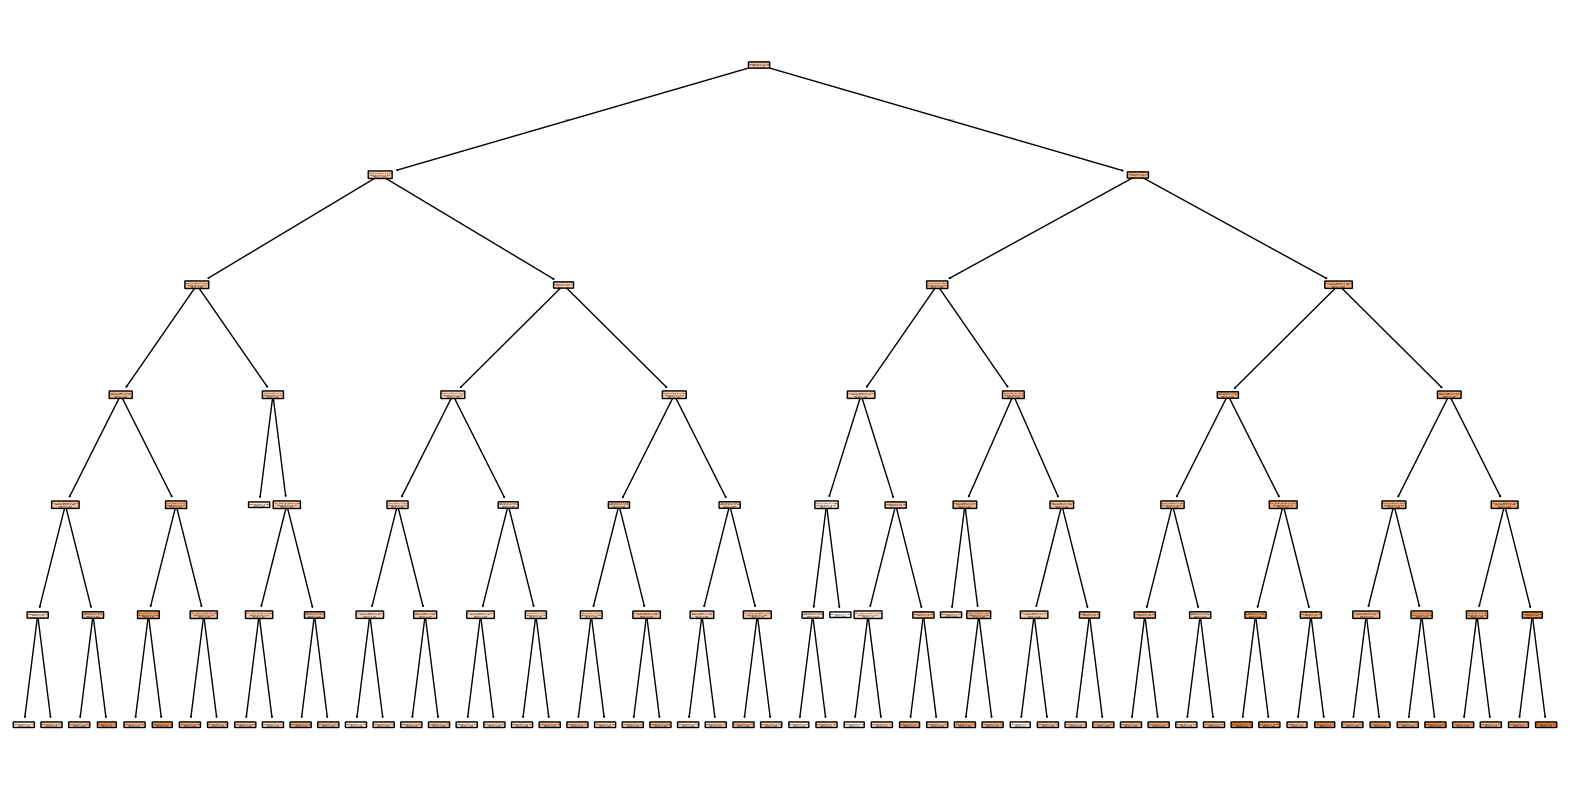

In [142]:
# 📊 Dibujar el árbol
plt.figure(figsize=(20,10))  # Ajusta el tamaño de la imagen
plot_tree(best_model, feature_names=df.columns[:-1], filled=True, rounded=True)
plt.show()

Finalmente se adjunta una representacion grafica del DTS